In [1]:
from google.colab import drive
import os

# Drive 마운트
drive.mount('/content/drive')

# 파일 경로 설정
BASE_DIR = '/content/drive/MyDrive/AIHUB_DATA/'
TRAIN_FILE = BASE_DIR + 'train_set.json'
VALID_FILE = BASE_DIR + 'valid_set.json'

Mounted at /content/drive


In [2]:
import json
from typing import List, Tuple
from datasets import Dataset
import os # 파일 경로 확인을 위해 필요

MAX_TRAIN_SAMPLES = 20000 # 학습 데이터를 2만 쌍으로 제한
MAX_VALID_SAMPLES = 2000 # 검증 데이터는 2천 쌍으로 제한

def preprocess_aihub_json(file_path: str, max_samples: int) -> List[Tuple[str, str]]:
    """AI HUB JSON 파일을 읽고 지정된 개수만큼의 영어('en') -> 한국어('ko') 쌍을 추출합니다."""
    en_ko_pairs = []

    if not os.path.exists(file_path):
        print(f" 경고: 파일을 찾을 수 없습니다: {file_path}")
        return en_ko_pairs

    # ... (파일 로드 및 오류 처리 코드)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터 추출 및 제한 로직 추가
    for item in data.get('data', []):
        if len(en_ko_pairs) >= max_samples:
            break # 지정된 샘플 개수에 도달하면 추출 종료

        english = item.get('en')
        korean = item.get('ko')

        # 유효성 검사
        if english and korean and english.strip() and korean.strip():
            en_ko_pairs.append((english.strip(), korean.strip()))

    return en_ko_pairs

#  학습 및 검증 데이터 로드
aihub_train_data = preprocess_aihub_json(TRAIN_FILE, MAX_TRAIN_SAMPLES)
aihub_valid_data = preprocess_aihub_json(VALID_FILE, MAX_VALID_SAMPLES)

# Hugging Face Dataset 객체로 변환
def convert_to_dataset_format(data_list):
    sources = [item[0] for item in data_list]
    targets = [item[1] for item in data_list]
    return {"translation": [{"en": src, "ko": tgt} for src, tgt in zip(sources, targets)]}

train_dataset = Dataset.from_dict(convert_to_dataset_format(aihub_train_data))
valid_dataset = Dataset.from_dict(convert_to_dataset_format(aihub_valid_data))

print(f" 학습 데이터 쌍 총 개수: {len(aihub_train_data)}개 ")
print(f" 검증 데이터 쌍 총 개수: {len(aihub_valid_data)}개 ")

 학습 데이터 쌍 총 개수: 20000개 
 검증 데이터 쌍 총 개수: 2000개 


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from datasets import Dataset
import json
import os

MAX_TRAIN_SAMPLES = 20000
MAX_VALID_SAMPLES = 2000

# 1. 모델 로드, 토크나이저 로드
MODEL_NAME = "facebook/mbart-large-cc25"
print(f"모델 아키텍처 로드 시작: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    force_download=True
)
print(" 모델 및 토크나이저 로드 완료.")

# 2. GPU로 모델 이동 확인
if torch.cuda.is_available():
    print(f" 모델이 GPU({model.device})로 성공적으로 이동했습니다.")
else:
    print(" GPU를 찾을 수 없습니다. 설정 확인이 필요합니다.")

# 3. 데이터 로드 및 토큰화 (수정된 로직)

def preprocess_aihub_json(file_path: str, max_samples: int) -> List[Tuple[str, str]]:
    """AI HUB JSON 파일을 읽고 지정된 개수만큼의 영어-한국어 쌍을 추출합니다."""
    en_ko_pairs = []

    if not os.path.exists(file_path):
        print(f" 경고: 파일을 찾을 수 없습니다: {file_path}")
        return en_ko_pairs

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for item in data.get('data', []):
        if len(en_ko_pairs) >= max_samples:
            break # 지정된 샘플 개수에 도달하면 종료

        english = item.get('en')
        korean = item.get('ko')

        if english and korean and english.strip() and korean.strip():
            en_ko_pairs.append((english.strip(), korean.strip()))
    return en_ko_pairs

# 훈련/검증 데이터셋 로드
aihub_train_data = preprocess_aihub_json(TRAIN_FILE, MAX_TRAIN_SAMPLES)
aihub_valid_data = preprocess_aihub_json(VALID_FILE, MAX_VALID_SAMPLES)

def convert_to_dataset_format(data_list):
    sources = [item[0] for item in data_list]
    targets = [item[1] for item in data_list]
    return {"translation": [{"en": src, "ko": tgt} for src, tgt in zip(sources, targets)]}

train_dataset = Dataset.from_dict(convert_to_dataset_format(aihub_train_data))
valid_dataset = Dataset.from_dict(convert_to_dataset_format(aihub_valid_data))
print(f" 학습 데이터 쌍 총 개수: {len(aihub_train_data)}개 ")

# 4. 데이터 토큰화
MAX_LENGTH = 50

def tokenize_function(examples):
    tokenizer.src_lang = "en_XX"
    model_inputs = tokenizer([ex["en"] for ex in examples["translation"]], max_length=MAX_LENGTH, truncation=True)

    tokenizer.tgt_lang = "ko_KR"
    with tokenizer.as_target_tokenizer():
        labels = tokenizer([ex["ko"] for ex in examples["translation"]], max_length=MAX_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 데이터셋에 토큰화 적용
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_datasets = valid_dataset.map(tokenize_function, batched=True)

print(" 데이터셋 토큰화 완료.")

try:
    test_sentence = "Hello, this is a test sentence in English."
    tokenizer.src_lang = "en_XX"
    tokens = tokenizer(test_sentence, return_tensors="pt")

    decoded_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

    tokenizer.tgt_lang = "ko_KR"

    print(" 토크나이저 로드 및 기본 작동 확인 완료.")
    print(f"테스트 문장: {test_sentence}")
    print(f"디코딩 결과: {decoded_text}")

except Exception as e:
    print(f"경고: 토크나이저 로드 또는 작동 테스트 중 오류 발생")
    print(f"오류 내용: {e}")

모델 아키텍처 로드 시작: facebook/mbart-large-cc25


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

 모델 및 토크나이저 로드 완료.
 모델이 GPU(cuda:0)로 성공적으로 이동했습니다.
 학습 데이터 쌍 총 개수: 20000개 


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

 데이터셋 토큰화 완료.
 토크나이저 로드 및 기본 작동 확인 완료.
테스트 문장: Hello, this is a test sentence in English.
디코딩 결과: Hello, this is a test sentence in English.


In [4]:
data_list=[
    {"document_id": "ml4e-lecture-week10",
    "pages": [
        {   "page_num": 3,
            "source_texts": [
                "Deep Learning",
                "Convolutional Neural Networks"
            ],
            "machine_translation": [
                "딥 러닝",
                "컨볼루션 신경망"
            ],
            "needs_correction": [False, True],
        },{
            "page_num": 4,
            "source_texts": [
                "What Computers “See”? ",
                "Images are numbers",
                "An image is just a matrix of numbers [0, 255]!",
                "i.e., $1080 \times 1080 \times 3$ for an RGB image"
            ],
            "machine_translation": [
                "컴퓨터가 '보는' 것은 무엇인가?",
                "이미지는 숫자이다",
                "이미지는 단지 [0, 255]범위의 숫자의 행렬입니다!",
                "즉, RGB 이미지의 경우 $1080 \times 1080 \times 3$크기입니다"
            ],
            "needs_correction": [False, False,False, False],
        },{
            "page_num": 5,
            "source_texts": [
                "Tasks in Computer Vision",
                "Regression: output variable takes continuous value",
                " Classification: output variable takes class label. Can produce probability of belonging to a particular class"
            ],
            "machine_translation": [
                "컴퓨터 비전의 과제",
                "회귀: 출력 변수는 연속 값을 취함",
                "분류: 출력 변수는 클래스 레이블을 취합니다. 특정 클래스에 속할 확률을 생성할 수 있습니다"
            ],
            "needs_correction": [False, False, False],
        },
        {
            "page_num": 6,
            "source_texts": [
                    "“Learning” Feature Representations",
                    "Motivation",
                    " The bird occupies a local area and looks the same in different parts of an image.",
                    " We should construct neural networks which exploit these properties."
            ],
            "machine_translation": [
                    "특징 표현의 '학습'",
                    "동기",
                    "새는 국소 영역을 차지하며 이미지의 다른 부분에서 동일하게 보입니다.",
                    "이러한 특성을 활용하는 신경망을 구성해야 합니다."
            ],
            "needs_correction": [False, False, False, False],
        },
        {
            "page_num": 7,
            "source_texts": [
                "Fully Connected Neural Network",
                "Input:",
                " 2D image",
                " Vector of pixel values",
                " Fully Connected:",
                " Connect neuron in hidden layer to all neurons in input layer",
                " No spatial information!",
                " Spatial organization of the input is destroyed by flatten.",
                " And, many, many parameters!",
                " How can we use spatial structure in the input to inform the architecture of the network?"
            ],
            "machine_translation": [
                "완전 연결 신경망",
                "입력:",
                "2차원 이미지",
                "픽셀 값 벡터",
                "완전 연결:",
                "숨겨진 층의 뉴런을 입력 층의 모든 뉴런에 연결",
                "공간 정보 없음!",
                "입력의 공간적 구성은 평탄화(flatten)로 파괴됩니다.",
                "그리고, 매우 많은 매개변수!",
                "입력의 공간 구조를 어떻게 활용하여 네트워크 아키텍처를 설계할 수 있을까요?"
            ],
            "needs_correction": [False, False, False, False, False, False, False, False, False, False],
        },
        {
            "page_num": 8,
            "source_texts": [
                "Fully Connected Layer",
                "Example: 200x200 image 40K hidden units ~ 2B parameters",
                " Spatial correlation is local",
                " Waste of resources + we have not enough training samples anyway.."
            ],
            "machine_translation": [
                "완전 연결된 레이어",
                "예시: 200x200 이미지 40K 숨겨진 유닛 ~ 2B 매개변수",
                "공간적 상관관계는 국소적",
                "자원 낭비 + 어차피 충분한 훈련 샘플이 없음.."
            ],
            "needs_correction": [True, False, False, False],
        },
        {
            "page_num": 9,
            "source_texts": [
                "Locally Connected Layer",
                "Example: 200x200 image 40K hidden units Filter size: 10x10 4M parameters",
                "Note: This parameterization is go when impur image is registere(e.face recognition)."
            ],
            "machine_translation": [
                "국소 연결 레이어",
                "예시: 200x200 이미지 40K 숨겨진 유닛 필터 크기: 10x10 4M 매개변수",
                "참고: 이 매개변수화는 이미지가 정렬된 경우(예: 얼굴 인식)에 적합합니다."
            ],
            "needs_correction": [False, False, False],
        },
        {
            "page_num": 10,
            "source_texts": [
                "Convolutional Layer",
                "Share the same parameters across different locations(assuming imput is stationary): Convolutions with learned kernels"
            ],
            "machine_translation": [
                "Convolutional Layer",
                "Share the same parameters across different locations(assuming imput is stationary): Convolutions with learned kernels"
            ],
            "needs_correction": [True, True],
        },{
            "page_num": 11,
            "source_texts": [
                "Key Idea",
                " A standard neural net applied to images:",
                " Scales quadratically with the size of the input",
                " Does not leverage stationarity",
                " Solution:",
                " Connect each hidden unit to a small patch of the input",
                " Share the weight across space",
                " This is called: convolutional layer.",
                " A network with convolutional layers is called convolutional network."
            ],
            "machine_translation": [
                "핵심 개념",
                "이미지에 적용되는 표준 신경망:",
                "입력 크기에 따라 제곱적으로 확장됨",
                "정역성을 활용하지 않음",
                "해결책:",
                "각 숨겨진 유닛을 입력의 작은 패치에 연결",
                "공간 전반에 걸쳐 가중치를 공유",
                "이를 다음과 같이 부릅니다: 컨볼루션 레이어.",
                " 컨볼루션 레이어를 가진 네트워크는 컨볼루션 네트워크라고 합니다."
            ],
            "needs_correction": [False, True, False, False, False, False, False, False, False],
        },{
            "page_num": 12,
            "source_texts": [
                "The Convolution Operation",
                " Filter (or Kernel):",
                " Discrete convolution can be viewed as element-wise multiplication by a matrix",
                " Modify or enhance an image by filtering",
                " Filter images to emphasize certain features or remove other features",
                " Filtering includes smoothing, sharpening, and edge enhancement",
                " The filter slides (or, “convolves”) across the image, repeating this operation for each overlapping region."
            ],
            "machine_translation": [
                "컨볼루션 연산",
                "필터(또는 커널):",
                "이산적 합성은 행렬과의 요소별 곱셈으로 볼 수 있습니다",
                "필터링을 통해 이미지를 수정하거나 향상시킵니다",
                "특정 특징을 강조하거나 다른 특징을 제거하기 위해 이미지를 필터링합니다",
                "필터링에는 평활화, 선명화, 가장자리 강화 등이 포함됩니다",
                "필터는 이미지를 가로질러 미끄러지며(또는 “합성”하며), 겹치는 각 영역에 대해 이 작업을 반복합니다."
            ],
            "needs_correction": [False, True, False, False, False, False, False],
        },{
            "page_num": 19,
            "source_texts": [
                "Spatial Pooling",
                "Sum, average, or max",
                "Non-overlapping / overlapping regions",
                "Role of pooling:",
                "Invariance to small transformations",
                "Larger receptive fields (see more of input)"
            ],
            "machine_translation": [
                "공간 풀링",
                "합계, 평균 또는 최대값",
                "비중첩 / 중첩 영역",
                "풀링의 역할:",
                "작은 변환에 대한 불변성",
                "더 큰 수용 영역(입력 더 많이 보기)"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 20,
            "source_texts": [
                "Convolutional Neural Networks",
                "Feed-forward feature extraction:",
                "Convolve input with learned filters: Apply filters to generate feature maps.",
                "Non-linearity: Often ReLU.",
                "Spatial pooling: Downsampling operation on each feature map.",
                "Normalization",
                "Supervised training of convolutional filters by back-propagating classification error"
            ],
            "machine_translation": [
                "컨볼루션 신경망",
                "피드포워드 특징 추출:",
                "학습된 필터로 입력을 컨볼루션: 필터를 적용하여 특징 맵 생성.",
                "비선형성: 종종 ReLU 사용.",
                "공간 풀링: 각 특징 맵에 대한 다운샘플링 연산.",
                "정규화",
                "분류 오류를 역전파하여 컨볼루션 필터의 지도 학습 수행"
            ],
            "needs_correction": [False, False, False, False, False, False, True],
        },{
            "page_num": 21,
            "source_texts": [
                "Important Concepts in CNN",
                "1. Convolution could have multiple filters."
            ],
            "machine_translation": [
                "CNN의 중요한 개념",
                "1. 컨볼루션은 여러 필터를 가질 수 있습니다."
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 22,
            "source_texts": [
                "Important Concepts in CNN",
                "1. Convolution could have multiple filters.",
                "2. For tensor (rank>=3), it still applies element-wise multiplication."
            ],
            "machine_translation": [
                "CNN의 중요한 개념",
                "1. 컨볼루션은 여러 필터를 가질 수 있습니다.",
                "2. 텐서(랭크>=3)의 경우에도 여전히 요소별 곱셈이 적용됩니다."
            ],
            "needs_correction": [False, False, True],
        },{
            "page_num": 23,
            "source_texts": [
                "Important Concepts in CNN",
                "1. Convolution could have multiple filters.",
                "2. For tensor (rank>=3), it still applies element-wise multiplication.",
                "3.  Stride is the size of filter step in sliding window."
            ],
            "machine_translation": [
                "CNN의 중요한 개념",
                "1. 컨볼루션은 여러 필터를 가질 수 있습니다.",
                "2. 텐서(랭크>=3)의 경우에도 여전히 요소별 곱셈이 적용됩니다.",
                "3. 스트라이드는 슬라이딩 윈도우에서 필터 단계의 크기입니다."
            ],
            "needs_correction": [False, False, True, False],
        },{
            "page_num": 24,
            "source_texts": [
                "Important Concepts in CNN",
                "1. Convolution could have multiple filters.",
                "2. For tensor (rank>=3), it still applies element-wise multiplication.",
                "3. Stride is the size of filter step in sliding window.",
                "4. By stacking convolutional layers, we can increase receptive field."
            ],
            "machine_translation": [
                "CNN의 중요한 개념",
                "1. 컨볼루션은 여러 필터를 가질 수 있습니다.",
                "2. 텐서(랭크>=3)의 경우에도 여전히 요소별 곱셈이 적용됩니다.",
                "3. 스트라이드는 슬라이딩 윈도우에서 필터 단계의 크기입니다.",
                "4. 컨볼루션 레이어를 쌓음으로써 수용 영역을 확대할 수 있습니다."
            ],
            "needs_correction": [False, False, True, False, False],
        },{
            "page_num": 25,
            "source_texts": [
                "Important Concepts in CNN",
                "1. Convolution could have multiple filters.",
                "2. For tensor (rank>=3), it still applies element-wise multiplication.",
                "3. Stride is the size of filter step in sliding window.",
                "4. By stacking convolutional layers, we can increase receptive field.",
                "5. To include pixels/neurons around the boundary of image, we need padding."
            ],
            "machine_translation": [
                "CNN의 중요한 개념",
                "1. 컨볼루션은 여러 필터를 가질 수 있습니다.",
                "2. 텐서(랭크>=3)의 경우에도 여전히 요소별 곱셈이 적용됩니다.",
                "3. 스트라이드는 슬라이딩 윈도우에서 필터 단계의 크기입니다.",
                "4. 컨볼루션 레이어를 쌓음으로써 수용 영역을 확대할 수 있습니다.",
                "5. 이미지 경계 주변의 픽셀/뉴런을 포함하려면 패딩이 필요합니다."
            ],
            "needs_correction": [False, False, True, False, False, False],
        },{
            "page_num": 27,
            "source_texts": [
                "Practice 1: Feature Map Shape",
                "OW, OH : output width, output height => output size",
                "IW, IH : input width, input height => input size",
                "FW, FH : filter width, filter height => filter size",
                "P : padding size",
                "S : stride"
            ],
            "machine_translation": [
                "실습 1: 피처 맵 형태",
                "OW, OH : 출력 너비, 출력 높이 => 출력 크기",
                "IW, IH : 입력 너비, 입력 높이 => 입력 크기",
                "FW, FH : 필터 너비, 필터 높이 => 필터 크기",
                "P : 패딩 크기",
                "S : 스트라이드"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 28,
            "source_texts": [
                "Practice 1: Feature Map Shape",
                "Stride = 1 (Default): Moves one pixel at a time",
                "Convolution with 3x3 kernel, zero padding and stride = 1"
            ],
            "machine_translation": [
                "실습 1: 피처 맵 형태",
                "스트라이드 = 1 (기본값): 한 번에 한 픽셀씩 이동",
                "3x3 커널, 제로 패딩 및 스트라이드 = 1을 사용한 컨볼루션"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 29,
            "source_texts": [
                "Practice 1: Feature Map Shape",
                "Stride > 1: Moves multiple pixels at a time → Reduces the output size, leading to downsampling.",
                "Convolution with 3x3 kernel, zero padding and stride = 2"
            ],
            "machine_translation": [
                "실습 1: 피처 맵 형태",
                "스트라이드 > 1: 한 번에 여러 픽셀 이동 → 출력 크기 감소, 다운샘플링 발생",
                "3x3 커널, 제로 패딩, 스트라이드 = 2를 사용한 컨볼루션"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 35,
            "source_texts": [
                "Sequence Modeling",
                "Sequence modeling is the task of predicting what comes next",
                "E.g., “This morning I took my dog for a walk.”",
                "E.g., given historical air quality, forecast air quality in next couple of hours."
            ],
            "machine_translation": [
                "시퀀스 모델링",
                "시퀀스 모델링은 다음에 올 것을 예측하는 작업입니다",
                "예: “오늘 아침 나는 개를 산책시켰다.”",
                "예: 과거 대기 질을 바탕으로 향후 몇 시간 동안의 대기 질을 예측한다"
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 36,
            "source_texts": [
                "A Sequence Modeling Example: Next Word Prediction",
                "Idea #1: Use a fixed window",
                "Limitation: Cannot model long-term dependencies",
                "E.g., “France is where I grew up, but I now live in Boston. I speak fluent ___.” ",
                "We need information from the distant past to accurately predict the correct word."
            ],
            "machine_translation": [
                "시퀀스 모델링 예시: 다음 단어 예측",
                "아이디어 #1: 고정 창 사용",
                "제한점: 장기적 의존성 모델링 불가",
                "예: “프랑스에서 자랐지만 지금은 보스턴에 살고 있습니다. 저는 유창한 ___를 구사합니다.”",
                "정확한 단어를 예측하려면 먼 과거의 정보가 필요합니다."
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 37,
            "source_texts": [
                "A Sequence Modeling Example: Next Word Prediction",
                "Idea #2: Use entire sequence as set of counts",
                " Bag-of-words model",
                "Define a vocabulary and initialize a zero vector where each element represents for each word",
                "Compute word frequency and update the correspond position in the vector",
                "Use the vector for prediction",
                "Limitation: Counts don’t preserve order",
                "“The food was good, not bad at all.” vs. “The food was bad, not good at all.”",
                "We need to preserve the information about order."
            ],
            "machine_translation": [
                "시퀀스 모델링 예시: 다음 단어 예측",
                "아이디어 #2: 전체 시퀀스를 카운트 집합으로 사용",
                "단어 백 모델",
                "어휘를 정의하고 각 요소가 각 단어를 나타내는 0 벡터를 초기화",
                "단어 빈도를 계산하고 벡터의 해당 위치를 업데이트",
                "예측에 벡터 사용",
                "제한 사항: 카운트는 순서를 보존하지 않음",
                "“음식이 좋았고, 전혀 나쁘지 않았어.” vs. “음식이 나빴고, 전혀 좋지 않았어.”",
                "순서에 대한 정보를 보존해야 합니다."
            ],
            "needs_correction": [False, False, True, False, False, False, False, False, False],
        },{
            "page_num": 38,
            "source_texts": [
                "Sequence Modeling",
                "To model sequences, we need to:",
                "Handle variable-length sequences",
                "Track long-term dependencies",
                "Maintain information about order",
                "Share parameters across the sequence",
                "Solution:",
                "Recurrent Neural Networks (RNNs)"
            ],
            "machine_translation": [
                "시퀀스 모델링",
                "시퀀스를 모델링하려면 다음이 필요합니다:",
                "가변 길이 시퀀스 처리",
                "장기적 의존성 추적",
                "순서에 대한 정보 유지",
                "시퀀스 전반에 걸쳐 매개변수 공유",
                "해결책:",
                "순환 신경망(RNNs)"
            ],
            "needs_correction": [False, False, False, False, False, False, False, False],
        },{
            "page_num": 39,
            "source_texts": [
                "Recurrent Neural Networks (RNNs)",
                "Apply a recurrence relation at every time step to process a sequence:",
                "Note: the same function and set of parameters are used at every time step",
                "This allows RNNs to maintain a memory of previous inputs, making them suitable for sequence modeling tasks."
            ],
            "machine_translation": [
                "순환 신경망(RNNs)",
                "시퀀스를 처리하기 위해 매 시간 단계마다 재귀 관계를 적용합니다:",
                "참고:  매 시간 단계마다 동일한 함수와 매개변수 집합이 사용됩니다",
                "이를 통해 RNN은 이전 입력에 대한 기억을 유지할 수 있어 시퀀스 모델링 작업에 적합합니다."
            ],
            "needs_correction": [False, False, False, False]
        },{
            "page_num": 40,
            "source_texts": [
                "Standard Feed-Forward Neural Network",
                "One to One",
                "\"Vanilla\" neural network"
            ],
            "machine_translation": [
                "표준 전방전달 신경망",
                "일대일",
                "기본 신경망"
            ],
            "needs_correction": [True, False, False]
        },{
            "page_num": 41,
            "source_texts": [
                "Recurrent Neural Networks",
                "One to Many, Many to One, Many to Many",
                "… and many other architectures and applications"
            ],
            "machine_translation": [
                "순환 신경망(RNNs)",
                "일대다, 다대일, 다대다",
                "... 그리고 기타 다양한 아키텍처와 응용 분야"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 42,
            "source_texts": [
                "RNN: State Update and Output",
                "Update hidden state, $f_w$",
                "Compute output vector"
            ],
            "machine_translation": [
                "RNN: 상태 업데이트 및 출력",
                "숨겨진 상태 업데이트, $f_w$",
                "출력 벡터 계산"
            ],
            "needs_correction": [False, True, False],
        },{
            "page_num": 43,
            "source_texts": [
                "RNN: Computational Graph across Time",
                "Represent as computational graph unrolled across time",
                "It uses gates to control the flow of information, allowing it to maintain a memory cell over long sequences."
            ],
            "machine_translation": [
                "RNN: 시간에 따른 계산 그래프",
                "시간에 따라 펼쳐진 계산 그래프로 표현",
                "정보 흐름을 제어하기 위해 게이트를 사용하여 긴 시퀀스 동안 메모리 셀을 유지할 수 있게 합니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 47,
            "source_texts": [
                "RNN: Computational Graph across Time",
                "Re-use the same weight matrices at every time step"
            ],
            "machine_translation": [
                "RNN: 시간에 따른 계산 그래프",
                "모든 시간 단계에서 동일한 가중치 행렬을 재사용합니다"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 48,
            "source_texts": [
                "RNN: Computational Graph across Time",
                "Compute the loss $\mathcal{L}_t$ by comparing $\hat{y}_t$ and $y_t$ ($y_t$ is ground truth)",
                "e.g., $\mathcal{L}_t = (\hat{y}_t - y_t)^2$"
            ],
            "machine_translation": [
                "RNN: 시간에 따른 계산 그래프",
                "$\hat{y}_t$와 $y_t$($y_t$는 실제 값)를 비교하여 손실 $\mathcal{L}_t$를 계산합니다",
                "예: $\mathcal{L}_t = (\hat{y}_t - y_t)^2$"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 49,
            "source_texts": [
                "RNN: Computational Graph across Time",
                "Total loss $\mathcal{L} = \sum_{t=1}^T \mathcal{L}_t$"
            ],
            "machine_translation": [
                "RNN: 시간에 따른 계산 그래프",
                "전체 손실 $\mathcal{L} = \sum_{t=1}^T \mathcal{L}_t$"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 50,
            "source_texts": [
                "RNN: Backpropagation Through Time",
                "For backpropagation, we need to compute the gradients w.r.t. $W_{hy}$, $W_{hh}$, and $W_{xh}$."
            ],
            "machine_translation": [
                "RNN: 시간에 따른 역전파",
                "역전파를 위해서는 $W_{hy}$, $W_{hh}$, 및 $W_{xh}$에 대한 기울기를 계산해야 합니다."
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 51,
            "source_texts": [
                "Standard RNN Gradient Flow",
                "Computing the gradient w.r.t. $h_0$ involves many factors of $W_{hh}$ + repeated gradient computation!"
            ],
            "machine_translation": [
                "표준 RNN 기울기 흐름",
                "$h_0$에 대한 기울기 계산에는 $W_{hh}$의 많은 요소와 반복된 기울기 계산이 포함됩니다!"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 52,
            "source_texts": [
                "Standard RNN Gradient Flow: Exploding Gradients",
                "Computing the gradient w.r.t. $h_0$ involves many factors of $W_{hh}$ + repeated gradient computation!",
                "Many values > 1: exploding gradients, Gradient clipping to scale big gradients",
                "Many values < 1: vanishing gradients, 1. Activation function, 2. Weight initialization, 3. Network architecture"
            ],
            "machine_translation": [
                "표준 RNN 기울기 흐름: 폭발하는 기울기",
                "$h_0$에 대한 기울기 계산에는 $W_{hh}$의 여러 요소와 반복된 기울기 계산이 포함됩니다!",
                "1보다 큰 값이 많음: 폭발하는 기울기, 큰 기울기를 조정하기 위한 기울기 클리핑",
                "1보다 큰 값이 많을 경우: 폭발하는 기울기, 1. 활성화 함수, 2. 가중치 초기화, 3. 네트워크 구조"
            ],
            "needs_correction": [False, False, False, True],
        },{
            "page_num": 54,
            "source_texts": [
                "Why is Exploding Gradient a Problem? ",
                " If the gradient becomes too big, then SGD update step becomes too big:",
                "This can be bad updates: we take too large a step and reach a weird and bad parameter configuration (with large loss)",
                "You think you’ve found a hill to climb, but suddenly you’re in Iowa.",
                "In the worst case, this will result in Inf or NaNin your network (then you have to restart training from an earlier checkpoint)"
            ],
            "machine_translation": [
                "왜 폭발하는 기울기가 문제인가?",
                "기울기가 너무 커지면 SGD 업데이트 단계가 너무 커집니다:",
                "이는 나쁜 업데이트가 될 수 있습니다: 너무 큰 단계를 밟아 이상하고 나쁜 매개변수 구성(큰 손실)에 도달하게 됩니다",
                "오를 언덕을 찾았다고 생각했는데, 갑자기 아이오와에 있는 자신을 발견하게 됩니다.",
                "최악의 경우, 네트워크에서 무한대(Inf)나 무한대(NaN)가 발생할 수 있습니다(그러면 이전 체크포인트에서 훈련을 다시 시작해야 합니다)"
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 55,
            "source_texts": [
                "Solution: Gradient Clipping",
                "Gradient clipping: if the norm of the gradient is greater than some threshold, scale it down before applying SGD update",
                "Intuition: take a step in the same direction, but a smaller step",
                "In practice: remembering to clip gradients is important, but exploding gradients are an easy problem to solve."
            ],
            "machine_translation": [
                "해결책: 기울기 클리핑",
                "경사 클리핑: 경사의 노름이 특정 임계값을 초과할 경우, SGD 업데이트 적용 전에 축소합니다",
                "직관: 동일한 방향으로 한 걸음 나아가되, 더 작은 걸음으로",
                "실제 적용: 경사 클리핑을 기억하는 것이 중요하지만, 폭발하는 경사는 해결하기 쉬운 문제입니다."
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 56,
            "source_texts": [
                "The Problem of Long-Term Dependencies",
                "Why are vanishing gradients a problem?",
                "Multiply many small numbers together",
                "Errors due to further back time steps have smaller and smaller gradients",
                "Bias parameters to capture short-term dependencies"
            ],
            "machine_translation": [
                "장기 의존성의 문제",
                "사라지는 기울기가 왜 문제인가?",
                "많은 작은 숫자들을 곱하기",
                "더 먼 시간 단계의 오류는 점점 더 작은 기울기를 가진다",
                "단기 의존성을 포착하기 위한 편향 매개변수"
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 57,
            "source_texts": [
                "Vanishing Gradient Intuition"
            ],
            "machine_translation": [
                "소멸하는 기울기의 직관적 이해"
            ],
            "needs_correction": [False],
        },{
            "page_num": 60,
            "source_texts": [
                "Vanishing Gradient Intuition",
                "Vanishing gradient problem: When these are small, the gradient signal gets smaller and smaller as it backpropagates further"
            ],
            "machine_translation": [
                "소멸하는 기울기의 직관적 이해",
                "소멸하는 기울기 문제: 이 값들이 작을 때, 기울기 신호는 역전파가 진행될수록 점점 더 작아진다"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 62,
            "source_texts": [
                "Why is Vanishing Gradient a Problem? ",
                "Gradient signal from far away is lost because it’s much smaller than gradient signal from close-by.",
                "So, model weights are basically updated only with respect to near effects, not long-term effects."
            ],
            "machine_translation": [
                "소멸하는 기울기가 문제인 이유는 무엇인가요?",
                "먼 곳에서 오는 기울기 신호는 가까운 곳에서 오는 신호보다 훨씬 작기 때문에 손실됩니다.",
                "따라서 모델 가중치는 기본적으로 장기적 영향이 아닌 근접한 영향에 대해서만 업데이트됩니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 63,
            "source_texts": [
                "Why is Vanishing Gradient a Problem? ",
                "LM task: When she tried to print her tickets, she found that the printer was out of toner. She went to the stationery store to buy more toner. It was very overpriced. After installing the toner into the printer, she finally printed her _______.",
                "To learn from this example, the RNN-LM needs to model the dependency between “tickets” on the 7th step and the target ord “tickets” at the end. ",
                " But if the gradient is small, the model can’t learn this dependency.",
                " So, the model is unable to predict similar long-distance dependencies at test time.",
                " In practice, a simple RNN will only condition ~7 tokens back. "
            ],
            "machine_translation": [
                "소멸하는 기울기(Vanishing Gradient)가 문제인 이유는 무엇인가요?",
                "LM 작업: 그녀가 티켓을 인쇄하려고 했을 때, 프린터의 토너가 다 떨어진 것을 발견했습니다. 그녀는 문구점에 가서 토너를 더 사러 갔습니다. 가격이 매우 비쌌습니다. 프린터에 토너를 설치한 후, 그녀는 마침내 티켓을 인쇄했습니다.",
                "이 예에서 학습하려면 RNN-LM은 7번째 단계의 ‘tickets'와 마지막 목표 단어 'tickets’ 사이의 의존성을 모델링해야 합니다.",
                "그러나 기울기가 작으면 모델은 이 의존성을 학습할 수 없습니다.",
                "따라서 모델은 테스트 시 유사한 장거리 의존성을 예측할 수 없습니다.",
                "실제로, 단순한 RNN은 약 7개의 토큰만 조건부로 전달합니다."
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 64,
            "source_texts": [
                "Solution: Gating Mechanisms in Neurons",
                "Use a more complex recurrent unit with gates to control what information is passed through",
                "Long Short-Term Memory (LSTM) networks rely on gated cells to track information throughout many time steps.",
                "Intuition: could we design an RNN with separate memory which is added to?"
            ],
            "machine_translation": [
                "해결책: 뉴런의 게이트 메커니즘",
                "정보 전달을 제어하는 게이트가 있는 더 복잡한 재귀 유닛 사용",
                "장단기 메모리(LSTM) 네트워크는 여러 시간 단계에 걸쳐 정보를 추적하기 위해 게이트 셀에 의존합니다.",
                "직관: 추가되는 별도의 메모리를 가진 RNN을 설계할 수 있을까?"
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 65,
            "source_texts": [
                "Standard RNNs",
                "In a standard RNN, recurrent modules contain simple computation"
            ],
            "machine_translation": [
                "표준 RNN",
                "표준 RNN에서 재귀 모듈은 간단한 연산을 포함합니다"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 66,
            "source_texts": [
                "Long Short-Term Memory (LSTM)",
                "In an LSTM network, recurrent modules contain gated cells that control the information flow"
            ],
            "machine_translation": [
                "Long Short-Term Memory (LSTM)",
                "In an LSTM network, recurrent modules contain gated cells that control the information flow"
            ],
            "needs_correction": [True, True],
        },{
            "page_num": 67,
            "source_texts": [
                "Long Short-Term Memory (LSTM)",
                "Besides hidden state $h_t$ (same as RNN), LSTM maintains a cell state $c_t$, where it’s easy for information to flow."
            ],
            "machine_translation": [
                "장단기 메모리(LSTM)",
                "은닉 상태 $h_t$ (RNN과 동일) 외에도, LSTM은 정보 흐름이 용이한 셀 상태 $c_t$를 유지합니다."
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 68,
            "source_texts": [
                "Long Short-Term Memory (LSTM)",
                "Information is added or removed to cell state through structures called gates.",
                "Gates optionally let information through, via a sigmoid layer and pointwise multiplication"
            ],
            "machine_translation": [
                "장단기 기억(LSTM)",
                "정보는 게이트라고 불리는 구조를 통해 셀 상태에 추가되거나 제거됩니다.",
                "게이트는 시그모이드 층과 점별 곱셈을 통해 선택적으로 정보를 통과시킵니다"
            ],
            "needs_correction": [True, False, True],
        },{
            "page_num": 69,
            "source_texts": [
                "LSTM: Forget Irrelevant Information",
                "Concatenate previous hidden state and current input",
                "When $\sigma$ outputs 0, the network will “completely forget” the information from $c_{t-1}$.",
                "When $\sigma$ outputs 1, “completely keep”"
            ],
            "machine_translation": [
                "LSTM: 불필요한 정보 잊기",
                "이전 숨겨진 상태와 현재 입력을 연결",
                "$\sigma$가 0을 출력하면 네트워크는 $c_{t-1}$의 정보를 '완전히 잊어버린다.'",
                "$\sigma$가 1을 출력하면 '완전히 유지'합니다."
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 70,
            "source_texts": [
                "LSTM: Add New Information",
                "$\sigma$ decides what values to update",
                "$\tanh$ generates “candidate values” that could be added to cell state"
            ],
            "machine_translation": [
                "LSTM: 새로운 정보 추가",
                "$\sigma$는 업데이트할 값을 결정합니다",
                "$\tanh$는 셀 상태에 추가될 수 있는 '후보 값'을 생성합니다"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 71,
            "source_texts": [
                "LSTM: Update Cell State",
                "$f_t * c_{t-1}$ is to apply forget gate to previous cell state",
                "$i_t * \tilde{c}_t$ is to add new candidate values to cell state"
            ],
            "machine_translation": [
                "LSTM: 셀 상태 업데이트",
                "$f_t * c_{t-1}$은 이전 셀 상태에 잊음 게이트를 적용하는 것",
                "$i_t * \tilde{c}_t$는 새로운 후보 값을 셀 상태에 추가하는 것"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 72,
            "source_texts": [
                "LSTM: Output Filtered Version of Cell State",
                "$\sigma$ decides what parts of the cell state to output as current hidden state",
                "$\tanh$ squashes values between -1 and 1",
                "$o_t * \tanh(c_t)$ is to output filtered version of cell",
                "$h_t$ will be used to compute $\hat{y}_t$"
            ],
            "machine_translation": [
                "LSTM: 필터링된 셀 상태 버전 출력",
                "$\sigma$는 셀 상태의 어떤 부분을 현재 숨겨진 상태로 출력할지 결정합니다",
                "$\tanh$는 값을 -1과 1 사이로 압축합니다",
                "$o_t * \tanh(c_t)$는  필터링된 셀 버전을 출력하기 위한 것입니다 ",
                "$h_t$는 $\hat{y}_t$를 계산하는 데 사용될 것입니다"
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 73,
            "source_texts": [
                "LSTM: Cell State Matters",
                "The information flows through cell state $c_t$.",
                "You can think of the LSTM equations visually like this:"
            ],
            "machine_translation": [
                "LSTM: 셀 상태의 중요성",
                "정보는 셀 상태 $c_t$를 통해 흐릅니다.",
                "LSTM 방정식을 시각적으로 이렇게 생각할 수 있습니다:"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 77,
            "source_texts": [
                "LSTM: Key Concepts",
                " Maintain a separate cell state from what is outputted",
                " Use gates to control the flow of information",
                " Forget gate gets rid of irrelevant information",
                " Selectively updates cell state",
                " Output gate returns a filtered version of the cell state",
                " LSTM can mitigate vanishing gradient problem"
            ],
            "machine_translation": [
                "LSTM: 핵심 개념",
                "출력되는 내용과 별개의 셀 상태를 유지합니다",
                "게이트를 사용하여 정보 흐름을 제어합니다",
                "잊기 게이트는 관련 없는 정보를 제거합니다",
                "셀 상태를 선택적으로 업데이트합니다",
                "출력 게이트는 필터링된 버전의 셀 상태를 반환합니다",
                "LSTM은 소멸하는 기울기 문제를 완화할 수 있습니다"
            ],
            "needs_correction": [False, False, False, False, False, False, False],
        },{
            "page_num": 78,
            "source_texts": [
                "Supplementary: Residual Connection",
                " Is vanishing/exploding gradient just an RNN problem?",
                " No! It can be a problem for all neural architectures (including feed-forward and convolutional neural networks), especially very deep ones.",
                " Due to chain rule / choice of nonlinearity function, gradient can become vanishingly small as it backpropagates",
                " Thus, lower layers are learned very slowly (i.e., are hard to train)",
                " Another solution: lots of new deep feedforward/convolutional architectures add more direct connections (thus allowing the gradient to flow)",
                " For example:",
                " Residual connects a.k.a. “ResNet”",
                " Also known as skip-connections",
                " The identity connection preserves information by default",
                " This makes deep networks much easier to train"
            ],
            "machine_translation": [
                "보충 설명: 잔차 연결",
                "소멸/폭발하는 기울기는 RNN만의 문제인가?",
                "아니다! 이는 모든 신경망 구조(피드포워드 및 컨볼루션 신경망 포함), 특히 매우 깊은 구조에서 문제가 될 수 있다.",
                "연쇄 법칙/비선형 함수의 선택으로 인해, 역전파 과정에서 기울기가 소멸적으로 작아질 수 있습니다",
                "따라서 하위 계층은 매우 느리게 학습됩니다 (즉, 훈련이 어렵습니다)",
                "또 다른 해결책: 많은 새로운 심층 전이/컨볼루션 아키텍처는 더 많은 직접 연결을 추가합니다 (이로써 기울기가 흐를 수 있게 함)",
                "예를 들어:",
                "잔차 연결 일명 'ResNet'",
                "스킵 연결(skip-connections)이라고도 함",
                "동일 연결(identity connection)은 기본적으로 정보를 보존함",
                "이로 인해 심층 네트워크 훈련이 훨씬 용이해짐"
            ],
            "needs_correction": [False, False, False, False, False, False, False, False, False, False, False],
        },{
            "page_num": 79,
            "source_texts": [
                "RNN Applications",
                "RNNs can be used for sequence tagging",
                "e.g., part-of-speech tagging, named entity recognition"
            ],
            "machine_translation": [
                "RNN 응용 분야",
                "RNN은 시퀀스 태깅에 활용될 수 있음",
                "예: 품사 태깅, 명명된 엔티티 인식"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 80,
            "source_texts": [
                "RNN Applications",
                "RNNs can be used as a sentence encoder model",
                "e.g., sentiment classification",
                "How to compute sentence encoding?",
                "Basic way: use final hidden state",
                "Usually better: Take element-wise max or mean of all hidden states"
            ],
            "machine_translation": [
                "RNN 응용",
                "RNN은 문장 인코더 모델로 활용될 수 있습니다",
                "예: 감정 분류",
                "문장 인코딩은 어떻게 계산하나요?",
                "기본 방법: 최종 숨겨진 상태 사용",
                "일반적으로 더 우수: 모든 숨겨진 상태의 요소별 최대값 또는 평균값 취하기"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 83,
            "source_texts": [
                "RNN Applications",
                "RNNs can be used to generate text based on other information",
                "e.g., speech recognition, machine translation, summarization"
            ],
            "machine_translation": [
                "RNN 응용 분야",
                "RNN은 다른 정보를 기반으로 텍스트를 생성하는 데 사용될 수 있습니다",
                "예: 음성 인식, 기계 번역, 요약"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 85,
            "source_texts": [
                "Bidirectional and Multi-layer RNNs",
                "Motivation",
                "We can regard this hidden state as a representation of the word “terribly” in the context of this sentence. We call this a contextual representation.",
                "These contextual representations only contain information about the left context (e.g., “the movie was”).",
                "What about right context?",
                "In this example, “exciting” is in the right context and this modifies the meaning of “terribly” (from negative to positive)"
            ],
            "machine_translation": [
                "양방향 및 다층 RNN",
                "동기",
                "이 숨겨진 상태를 이 문맥에서 'terribly'라는 단어의 표현으로 볼 수 있습니다. 이를 문맥적 표현이라고 부릅니다.",
                "이러한 맥락적 표현은 왼쪽 문맥(예: 'the movie was')에 대한 정보만 포함합니다.",
                "오른쪽 문맥은 어떨까요?",
                "이 예시에서 'exciting'은 오른쪽 문맥에  위치하며, 이는 “terribly”의 의미를 부정적에서 긍정적으로 수정합니다."
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 87,
            "source_texts": [
                "Bidirectional RNNs",
                "This is a general notation to mean “compute one forward step of the RNN” :it could be a simple RNN or LSTM computation.",
                "We regard this as “the hidden state” of a bidirectional RNN",
                "This is what we pass on the next parts of the network.",
                "Generally, these two RNNs have separate weights"
            ],
            "machine_translation": [
                "양방향 RNN",
                "이는 RNN의 한 단계 전진 계산을 수행한다'는 일반적인 표기법입니다: 단순 RNN이나 LSTM 계산일 수 있습니다.",
                "우리는 이를 양방향 RNN의 '은닉 상태'로 간주합니다",
                "이것이 네트워크의 다음 부분으로 전달되는 내용입니다.",
                "일반적으로 이 두 RNN은 별도의 가중치를 가집니다"
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 88,
            "source_texts": [
                "Bidirectional RNNs: Simplified Diagram",
                "The two-way arrows indicate bidirectionality and the depicted hidden states are assumed to be the concatenated forwards+backwards states"
            ],
            "machine_translation": [
                "양방향 RNN: 간단한 다이어그램",
                "양방향 화살표는 양방향성을 나타내며, 표시된 숨겨진 상태는 전방+후방 상태를 연결한 것으로 가정합니다"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 89,
            "source_texts": [
                "Bidirectional RNNs",
                "Note: bidirectional RNNs are only applicable if you have access to the entire input sequence",
                "They are not applicable to Language Modeling, because in LM you only have left context available.",
                "If you do have entire input sequence (e.g., any kind of encoding), bidirectionality is powerful (you should use it by default).",
                "For example, BERT (Bidirectional Encoder Representations from Transformers) is a powerful pretrained contextual representation system built on bidirectionality.",
                "You will learn more about transformers, including BERT, in a couple of weeks!"
            ],
            "machine_translation": [
                "양방향 RNN",
                "참고: 양방향 RNN은 전체 입력 시퀀스에 접근할 수 있는 경우에만 적용 가능합니다",
                "언어 모델링(LM)에는 적용할 수 없습니다. LM에서는 왼쪽 컨텍스트만 사용할 수 있기 때문입니다.",
                "전체 입력 시퀀스(예: 모든 종류의 인코딩)가 있다면 양방향성은 강력합니다(기본적으로 사용해야 합니다).",
                "예를 들어, BERT(Bidirectional Encoder Representations from Transformers)는 양방향성을 기반으로 구축된 강력한 사전 훈련된 문맥 표현 시스템입니다.",
                "BERT를 포함한 트랜스포머에 대해 몇 주 후에 더 자세히 배우게 될 것입니다!"
            ],
            "needs_correction": [False, True, False, False, False, False],
        },{
            "page_num": 90,
            "source_texts": [
                "Multi-layer RNNs",
                "RNNs are already “deep” on one dimension (they unroll over many timesteps)",
                "We can also make them “deep” in another dimension by applying multiple RNNs: this is a multi-layer RNN.",
                "This allows the network to compute more complex representations",
                "The lower RNNs should compute lower-level features and the higher RNNs should compute higher-level features.",
                "Multi-layer RNNs are also called stacked RNNs"
            ],
            "machine_translation": [
                "다중층 RNN",
                "RNN은 이미 한 차원에서 ‘깊다’(여러 시간 단계에 걸쳐 전개됨)",
                "여러 RNN을 적용하여 다른 차원에서도  ‘깊게’ 만들 수 있다: 이것이 다중층 RNN이다.",
                "이를 통해 네트워크는 더 복잡한 표현을 계산할 수 있습니다",
                "하위 RNN은 하위 레벨 특징을, 상위 RNN은 상위 레벨 특징을 계산해야 합니다.",
                "다중 레이어 RNN은 스택형 RNN이라고도 합니다"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 92,
            "source_texts": [
                "Multi-layer RNNs",
                "Multi-layer or stacked RNNs allow a network to compute more complex representations: they work better than just one layer of high-dimensional encodings!",
                "The lower RNNs should compute lower-level features and the higher RNNs should compute higher-level features.",
                "High-performing RNNs are usually multi-layer (but aren’t as deep as convolutional or feed-forward networks)",
                "For example: In a 2017 paper, Britz et al. find that for Neural Machine Translation, 2 to 4 layers is best for encoder RNN, and 4 layers is best for the decoder RNN",
                "Often 2 layers is a lot better than 1, and 3 might be a little better than 2",
                "Usually, skip-connections/dense-connections are needed to train deeper RNNs (e.g., 8 layers)",
                "Transformer-based networks (e.g., BERT) are usually deeper, like 12 or 24 layers.",
                "You will learn about Transformers later; they have a lot of skipping-like connections."
            ],
            "machine_translation": [
                "다중 레이어 RNN",
                "다중 레이어 또는 스택형 RNN은 네트워크가 더 복잡한 표현을 계산할 수 있게 합니다: 고차원 인코딩의 단일 레이어보다 더 효과적으로 작동합니다!",
                "하위 RNN은 하위 수준의 특징을 계산해야 하며 상위 RNN은 상위 수준의 특징을 계산해야 합니다.",
                "고성능 RNN은 일반적으로 다중레이어 구조를 가집니다(하지만 컨볼루션 네트워크나 피드포워드 네트워크만큼 깊지는 않습니다)",
                "예를 들어: 2017년 논문에서 Britz 등은 신경망 기계 번역(NMT)의 경우 인코더 RNN에는 2~4층이 최적이며 디코더 RNN에는 4층이 최적이라고 밝혔습니다",
                "종종 2층이 1층보다 훨씬 우수하며, 3층은 2층보다 약간 더 나을 수 있습니다",
                "일반적으로 더 깊은 RNN(예: 8층)을 훈련하려면 스킵 연결/밀집 연결이 필요합니다",
                "트랜스포머 기반 네트워크(예: BERT)는 일반적으로 12층 또는 24층처럼 더 깊습니다.",
                "트랜스포머에 대해서는 나중에 배우게 될 것입니다; 스킵 연결과 유사한 연결이 많이 있습니다."
            ],
            "needs_correction": [False, False, False, False, False, False, False, False, False],
        },{
            "page_num": 93,
            "source_texts": [
                "RNN Limitations",
                " Limitations",
                " Encoding bottleneck: Fixed-size hidden state → information loss",
                " Slow, no parallelization: Step-by-step processing → slow on long sequences",
                " Not long memory: Vanishing/exploding gradients → weak long-term dependency"
            ],
            "machine_translation": [
                "RNN 한계점",
                "한계",
                "인코딩 병목 현상: 고정 크기 숨겨진 상태 → 정보 손실",
                "느림, 병렬화 불가: 단계별 처리 → 긴 시퀀스에서 느림",
                "장기 기억 부족: 소멸/폭발하는 기울기 → 약한 장기 의존성"
            ],
            "needs_correction": [False, False, False, False, False],
        }
    ]
},{
    "document_id": "ml4e-lecture-week9",
    "pages": [
        {
            "page_num": 2,
            "source_texts": [
                "Unsupervised Learning",
                "Dimensionality Reduction: Principal Component Analysis (PCA)"
            ],
            "machine_translation": [
                "비지도 학습",
                "차원 축소: 주성분 분석(PCA)"
            ],
            "needs_correction": [False, False],
        },{
            "page_num": 3,
            "source_texts": [
                "Why reduce dimensions?",
                "High dimensionality has many costs (a.k.a. Curse of Dimensionality)",
                "Computation may become infeasible",
                "What if your algorithm scales as O(n^3)?",
                "Redundant and irrelevant features degrade performance of some ML algorithms",
                "Difficulty in interpretation and visualization",
                "Storage requirements getting bigger"
            ],
            "machine_translation": [
                "왜 차원을 줄여야 할까?",
                "고차원성은 많은 비용을 초래합니다(일명 차원의 저주)",
                "계산이 불가능해질 수 있습니다",
                "알고리즘이 O(n^3)로 확장된다면?",
                "중복되고 관련 없는 특징은 일부 머신러닝 알고리즘의 성능을 저하시킵니다",
                "해석과 시각화의 어려움",
                "저장 공간 요구량이 커집니다"
            ],
            "needs_correction": [False, False, False, False, False, False, False],
        },{
            "page_num": 4,
            "source_texts": [
                "Principal Component Analysis (PCA)",
                " The 1st PC is the projection direction that maximizes the variance of the projected data",
                " The 2nd PC is the projection direction that is orthogonal to the 1st PC and maximizes the variance"
            ],
            "machine_translation": [
                "주성분 분석(PCA)",
                "1차 주성분은 투영된 데이터의 분산을 최대화하는 투영 방향입니다",
                "2차 주성분은 1차 주성분에 직교하면서 분산을 최대화하는 투영 방향입니다"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 5,
            "source_texts": [
                "Principal Component Analysis (PCA)",
                "Principal components are linear combinations of the original variables that have the maximum variance compared to other linear combinations.",
                "Essentially, these components capture as much information from the original datasets as possible."
            ],
            "machine_translation": [
                "주성분 분석(PCA)",
                "주성분은 다른 선형 조합에 비해 최대 분산을 가지는 원본 변수의 선형 조합입니다.",
                "본질적으로, 이러한 성분들은 원본 데이터 세트에서 가능한 한 많은 정보를 포착합니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 9,
            "source_texts": [
                "PCA Algorithm: Maximize Variance",
                "Find unit vector u such that maximizes variance of projections",
                "Note: $m \approx m - 1$ for big data"
            ],
            "machine_translation": [
                "PCA 알고리즘: 분산 극대화",
                "투영의 분산을 극대화하는 단위 벡터 u를 찾는다",
                "참고: 대용량 데이터의 경우 $m \approx m - 1$"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 10,
            "source_texts": [
                "Maximize Variance",
                "In an optimization form",
                "pick the largest eigenvalue $\lambda_1$ of covariance matrix $S$",
                "$u = u_1$ is the $\lambda_1$'s corresponding eigenvector",
                "$u_1$ is the first principal component (direction of highest variance in the data)"
            ],
            "machine_translation": [
                "분산 극대화",
                "최적화 형태로 표현하면",
                "공분산 행렬 $S$의 최대 고유값 $\lambda_1$ 선택",
                "여기서 $u = u_1$은 $\lambda_1$에 해당하는 고유벡터",
                "$u_1$은 첫 번째 주성분(데이터 내 최대 분산 방향)"
            ],
            "needs_correction": [False, False, False, False, False],
        },{
            "page_num": 11,
            "source_texts": [
                "Dimension Reduction Method ($n \rightarrow k$)",
                "1) Choose top $k$ (orthonormal) eigenvectors, $U = [u_1, u_2, ..., u_k]$",
                "2) Project $x_i$ onto span {$u_1, u_2, ..., u_k$}"
            ],
            "machine_translation": [
                "차원 축소 방법 ($n \rightarrow k$)",
                "1) 상위 $k$ (직교) 고유벡터 선택, $U = [u_1, u_2, ..., u_k]$",
                "2) $x_i$를 {$u_1, u_2, ..., u_k$}의 스팬에 투영합니다"
            ],
            "needs_correction": [False, False, True],
        },{
            "page_num": 12,
            "source_texts": [
                "Dimensionality Reduction Using PCA",
                " Calculate the covariance matrix of the data S",
                " Calculate the eigen-vectors/eigen-values of S",
                " Rank the eigen-values in decreasing order",
                " Select eigen-vectors that retain a fixed percentage of the variance, ",
                "(e.g., 80%, the smallest $d$ such that (Sum i=1 to d of lambda_i) / (Sum of lambda_i) $\geq 80\%$)"
            ],
            "machine_translation": [
                "PCA를 이용한 차원 축소",
                " 데이터의 공분산 행렬 S 계산",
                "S의 고유 벡터/고유 값 계산",
                "고유 값을 내림차순으로 정렬",
                "분산의 일정 비율을 유지하는 고유벡터를 선택합니다.",
                "(예: 80%, (Sum i=1 to d of lambda_i) / (Sum of lambda_i) $\geq 80\%$인 가장 작은 $d$)"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 13,
            "source_texts": [
                "PCA is a useful preprocessing step",
                " Helps reduce computational complexity.",
                " Can help supervised learning.",
                " Reduced dimension ➔ simpler hypothesis space.",
                " PCA can also be seen as noise reduction.",
                " Caveats:",
                " Fails when data consists of multiple separate clusters.",
                " Directions of greatest variance may not be most informative (i.e., greatest classification power)."
            ],
            "machine_translation": [
                "PCA는 유용한 전처리 단계입니다",
                "계산 복잡도를 줄이는 데 도움이 됩니다.",
                "지도 학습에 도움이 될 수 있습니다.",
                "차원 축소 ➔ 더 단순한 가설 공간.",
                "PCA는 잡음 감소로도 볼 수 있습니다.",
                "주의 사항:",
                "데이터가 여러 개의 분리된 클러스터로 구성될 때 실패합니다.",
                "가장 큰 분산 방향이 가장 유용한 정보(즉, 가장 큰 분류 능력)를 제공하지 않을 수 있습니다."
            ],
            "needs_correction": [False, False, False, False, False, False, False, False],
        }
    ]
},{
    "document_id": "NLP_10",
    "pages": [
        {   "page_num": 2,
            "source_texts": [
                "Sequence Labeling",
                "Input: a sequence of n tokens/words: ",
                "Pierre Vinken , 61 years old , will join IBM ‘s board as a nonexecutive director Nov. 29 ",
                "Output: a sequence of n labels, such that each token/word is associated with a label: "
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "입력: n개의 토큰/단어 시퀀스:",
                "Pierre Vinken , 61 years old , will join IBM ‘s board as a nonexecutive director Nov. 29 ",
                "Output: a sequence of n labels, such that each token/word is associated with a label: "
            ],
            "needs_correction": [False, False, False, True],
        },{
            "page_num": 3,
            "source_texts": [
                "Sequence Labeling",
                "POS Tagging",
                "Assign POS tags to words"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "품사 태깅",
                "단어에 품사 태그 할당"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 6,
            "source_texts": [
                "Sequence Labeling",
                "OShallow Parsing",
                " Identify all non-recursive NP, verb (“VP”) and preposition (“PP”) chunks"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "얕은 구문 분석",
                "모든 비재귀적 명사구(NP), 동사구('VP'), 전치사구('PP')를 식별합니다"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 7,
            "source_texts": [
                "Sequence Labeling",
                "BIO Encoding for Shallow Parsing",
                " We define three new tags: ",
                " B-NP B-VP B-PP: beginning of an NP, “VP”, “PP” chunk ",
                " I-NP I-VP I-PP: inside of an NP, “VP”, “PP” chunk",
                " O: outside of any chunk"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "얕은 구문 분석을 위한 BIO 인코딩",
                " 세 가지 새로운 태그를 정의합니다:",
                "B-NP B-VP B-PP: 명사구(NP), 동사구(VP), 전치사구(PP) 덩어리의 시작",
                "I-NP I-VP I-PP: 명사구(NP), 동사구(VP), 전치사구(PP) 덩어리 내부",
                "O: 모든 덩어리 외부"
            ],
            "needs_correction": [False, False, False, True, True, True],
        },{
            "page_num": 8,
            "source_texts": [
                "Sequence Labeling",
                "Named Entity Recognition",
                " Identify all mentions of named entities (people, organizations, locations, dates)"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "명명된 엔티티 인식",
                "명명된 엔티티(사람, 조직, 위치, 날짜)의 모든 언급 식별"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 9,
            "source_texts": [
                "Sequence Labeling",
                "BIO Encoding for NER",
                " We define many new tags: ",
                " B-PERS, B-DATE,...: beginning of a mention of a person/ date... ",
                " I-PERS, I-DATE,...: inside of a mention of a person/date..."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "NER을 위한 BIO 인코딩",
                "여러 새로운 태그를 정의합니다:",
                "B-PERS, B-DATE,...: 인물/날짜 등의 언급 시작",
                "I-PERS, I-DATE,...: 사람/날짜 등의 언급 내부"
            ],
            "needs_correction": [False, False, False, True, True],
        },{
            "page_num": 10,
            "source_texts": [
                "Sequence Labeling",
                "BIO Encoding for NER",
                " BIO encoding can be used to frame any task that requires the identification of nonoverlapping and non-nested text spans as a sequence labeling problem, e.g.: ",
                " NP chunking ",
                " Shallow Parsing ",
                " Named entity recognition"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "NER을 위한 BIO 인코딩",
                "BIO 인코딩은 중첩되지 않고 겹치지 않은 텍스트 범위의 식별이 필요한 모든 작업을 시퀀스 라벨링 문제로 구성하는 데 사용할 수 있습니다. 예:",
                "명사구 분할",
                "얕은 구문 분석",
                "명명된 엔티티 인식"
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 12,
            "source_texts": [
                "Sequence Labeling",
                "POS Tagging",
                "She promised to back the bill",
                "What is the most likely sequence of tags $t = t^{(1)}...t^{(N)}$ for the given sequence of words $w = w^{(1)}...w^{(N)}$?"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "품사 태깅",
                "그녀는 법안을 지지하겠다고 약속했다",
                "주어진 단어 시퀀스 $w = w^{(1)}...w^{(N)}$에 대해 가장 가능성이 높은 태그 시퀀스 $t = t^{(1)}...t^{(N)}$는 무엇인가?"
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 13,
            "source_texts": [
                "Sequence Labeling",
                "Hidden Markov Models (HMMs)",
                "HMMs are the most commonly used generative models for POS tagging (and other tasks, e.g. in speech recognition)",
                "HMMs make specific independence assumptions in P(t) and P(w|t):",
                "P(t) is an n-gram (typically bigram or trigram) model over tags:",
                "P(t_1^n) = ∏_i P(t_i | t_{i-1}, t_{i-2}) which are called transition probabilities",
                "In p(W|t), each w_i depends only on [is generated by/conditioned on] t_i",
                "P(W|t) = ∏_i P(w_i | t_i) which are called emission probabilities",
                "These probabilities don’t depend on the position in the sentence (i), but are defined over word and tag types."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "숨겨진 마르코프 모델(HMM)",
                "HMMs는 품사 태깅(및 음성 인식 등 다른 작업)에서 가장 일반적으로 사용되는 생성 모델입니다",
                "HMMs는 P(t) 및 P(w|t)에서 특정 독립성 가정을 합니다:",
                "P(t)는 태그에 대한 n-그램(일반적으로 바이그램 또는 트라이그램) 모델입니다:",
                "P(t_1^n) = ∏_i P(t_i | t_{i-1}, t_{i-2})는 전이 확률이라고 불립니다",
                "p(W|t)에서 각 w_i는 t_i에만 의존합니다 [t_i에 의해 생성되거나 조건부로 결정됩니다]",
                "P(W|t) = ∏_i P(w_i | t_i)는 방출 확률이라고 불립니다",
                "이러한 확률은 문장 내 위치(i)에 의존하지 않으며, 단어 및 태그 유형에 대해 정의됩니다."
            ],
            "needs_correction": [False, False, False, False, False, False, False, False, False],
        },{
            "page_num": 14,
            "source_texts": [
                "Sequence Labeling",
                "Notation",
                " To make the distinction between the i-th word/tag in the vocabulary/tag set and the i-th word/tag in the sentence clear: ",
                " Use superscript notation w^i for the i-th token in the sentence/sequence",
                " and subscript notation w_i for the i-th type in the inventory (tagset/vocabulary)"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "기호",
                "어휘/태그 세트의 i번째 단어/태그와 문장의 i번째 단어/태그를 명확히 구분하기 위해:",
                "문장/시퀀스의 i번째 토큰에 대해 위 첨자 표기법 w^i를 사용하고",
                "인벤토리(태그셋/어휘)의 i번째 유형에 대해 아래 첨자 표기법 w_i를 사용합니다"
            ],
            "needs_correction": [False, True, False, False],
        },{
            "page_num": 19,
            "source_texts": [
                "Sequence Labeling",
                "Building a HMM tagger",
                " To build a HMM tagger, we have to:",
                "Train the model, i.e. estimate its parameters (the transition and emission probabilities) ",
                "Easy case: We have a corpus labeled with POS tags (supervised learning) ",
                "Harder case: We have a corpus, but it’s just raw text without tags (unsupervised learning). ",
                "In that case it really helps to have a dictionary of which POS tags each word can have ",
                "Define and implement a tagging algorithm that finds the best tag sequence t* for each input sentence W:",
                "t* = argmax_T P(t)P(w|t)",
                "Viterbi algorithm"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "HMM 태거 구축",
                "HMM 태거를 구축하려면 다음을 수행해야 합니다:",
                "모델을 훈련시키기, 즉 매개변수(전환 확률 및 발현 확률) 추정",
                "쉬운 경우: 품사 태그가 지정된 코퍼스가 있는 경우 (지도 학습)",
                "더 어려운 경우: 코퍼스가 있지만 태그가 없는 원본 텍스트만 있는 경우 (비지도 학습).",
                "이 경우 각 단어가 가질 수 있는 품사 태그를 담은 사전이 있으면 정말 도움이 됩니다 ",
                "각 입력 문장 W에 대해 최상의 태그 시퀀스 t*를 찾는 태깅 알고리즘을 정의하고 구현하세요:",
                "t* = argmax_T P(t)P(w|t)",
                "비테르비 알고리즘"
            ],
            "needs_correction": [False, False, False, False, False, False, False, False],
        },{
            "page_num": 20,
            "source_texts": [
                "Sequence Labeling",
                "Learning a HMM from labeled data",
                " We count how often we see t_it_j and w_jt_i etc. in the data (use relative frequency estimates):",
                " Learning the transition probabilities: P(t_j | t_i) = C(t_i, t_j) / C(t_i) ",
                " Learining the emission probabilities: P(w_j | t_i) = C(t_i, w_j) / C(t_i) "
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "레이블이 지정된 데이터에서 HMM 학습",
                "데이터에서 t_it_j 및 w_jt_i 등의 출현 빈도를 계산합니다(상대 빈도 추정치 사용):",
                "전이 확률 학습: P(t_j | t_i) = C(t_i, t_j) / C(t_i)",
                "방출 확률 학습: P(w_j | t_i) = C(t_i, w_j) / C(t_i)"
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 21,
            "source_texts": [
                "Sequence Labeling",
                "HMM decoding (Viterbi)",
                "We are given a sentence w = w(1) ... w(N)",
                "w =“she promised to back the bill”",
                "We want to use an HMM tagger to find its POS tags ",
                "t* = argmax_T P(w,t)",
                "But, with T tags, w has has O(T^N possible tag sequences!",
                "To do this efficiently (in O(T^2N time), we will use a dynamic programming technique called the Viterbi algorithm which exploits the independence assumptions in the HMM."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "HMM 디코딩 (비테르비)",
                "문장 w = w(1) ... w(N)",
                "w = 'she promised to back the bill'",
                "HMM 태거를 사용하여 해당 품사 태그를 찾고자 합니다",
                "t* = argmax_T P(w,t)",
                "하지만 T개의 태그가 있는 경우, w는 O(T^N)개의 가능한 태그 시퀀스를 가집니다!",
                "이를 효율적으로 수행하기 위해 (O(T^2N) 시간 내에) 수행하기 위해, HMM의 독립성 가정을 활용하는 비테비 알고리즘이라는 동적 계획법 기법을 사용할 것입니다."
            ],
            "needs_correction": [False, False, False, False, False, False, True],
        },{
            "page_num": 22,
            "source_texts": [
                "Sequence Labeling",
                "Dynamic Programming",
                "Dynamic programming is a general technique to solve certain complex search problems by memoization",
                "Recursively decompose the large search problem into smaller subproblems that can be solved efficiently",
                "There is only a polynomial number of subproblems.",
                "Store (memoize) the solutions of each subproblem in a common data structure",
                "Processing this data structure takes polynomial time"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "동적 계획법",
                "동적 계획법은 메모이제이션을 통해 특정 복잡한 탐색 문제를 해결하는 일반적인 기법입니다",
                "대규모 탐색 문제를 효율적으로 해결할 수 있는 더 작은 하위 문제로 재귀적으로 분해합니다",
                "하위 문제의 수는 다항식 수준에 불과합니다",
                "각 하위 문제의 해법을 공통 데이터 구조에 저장(메모이제이션)합니다",
                "이 데이터 구조를 처리하는 데는 다항식 시간이 소요됩니다"
            ],
            "needs_correction": [False, False, False, False, False, False, False],
        },{
            "page_num": 23,
            "source_texts": [
                "Sequence Labeling",
                "The Viterbi algorithm",
                "A dynamic programming algorithm which finds the best (=most probable) tag sequence t* for an input sentence w: t* = argmax_T P(w|t)P(t)",
                "Complexity: linear in the sentence length. With a bigram HMM, Viterbi runs in O(T^2N) steps for an input sentence with N words and a tag set of T tags.",
                "The independence assumptions of the HMM tell us how to break up the big search problem (find t* = argmax_T P(w|t)P(t)) into smaller subproblems",
                "The data structure used to store the solution of these subproblems is the trellis"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "비테비 알고리즘",
                "동적 계획법 알고리즘으로, 입력 문장 w에 대해 최적(=가장 확률이 높은) 태그 시퀀스 t*를 찾는 알고리즘: t* = argmax_T P(w|t)P(t)",
                "복잡도: 문장 길이에 선형적. 2그램 HMM을 사용하면, N개의 단어로 구성된 입력 문장과 T개의 태그 집합에 대해 Viterbi는 O(T^2N) 단계로 실행됩니다.",
                "HMM의 독립성 가정은 거대한 검색 문제( t* = argmax_T P(w|t)P(t))를 더 작은 하위 문제로 분해하는 방법을 알려줍니다",
                "이러한 하위 문제들의 해법을 저장하는 데 사용되는 데이터 구조는 트렐리스입니다"
            ],
            "needs_correction": [False, True, False, True, False, False],
        },{
            "page_num": 24,
            "source_texts": [
                "Sequence Labeling",
                "The Viterbi algorithm",
                "We use a $N * T$ table (“trellis”) to keep track of the HMM. The HMM can assign one of the T tags to each of the N words."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "비테르비 알고리즘",
                "우리는 HMM을 추적하기 위해 $N * T$ 테이블('트렐리스')을 사용합니다. HMM은 N개의 단어 각각에 T개의 태그 중 하나를 할당할 수 있습니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 25,
            "source_texts": [
                "Sequence Labeling",
                "Viterbi: filling in the first column",
                "We want to find the best (most likely) tag sequence for the entire sentence.",
                "Each cell trellis[i][j] (corresponding to word W^(i) with tag t_j) contains:",
                "trellis[i][j].viterbi: the probability of the best sequence ending in t_j",
                "trellis[i][j].backpointer: to the cell k in the previous column that corresponds to the best tag sequence ending in t_j"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "비테르비: 첫 번째 열 채우기",
                "우리는 전체 문장에 대한 최상의(가장 가능성이 높은) 태그 시퀀스를 찾고자 합니다.",
                "각 셀 trellis[i][j] (단어 W^ (i)에 태그 t_j가 할당됨)에는 다음이 포함됩니다:",
                "trellis[i][j].viterbi: t_j에서 끝나는 최적 시퀀스의 확률",
                "trellis[i][j].backpointer: t_j에서 끝나는 최적 태그 시퀀스에 해당하는 이전 열의 셀 k로 연결됨"
            ],
            "needs_correction": [False, False, False, False, False, False],
        },{
            "page_num": 27,
            "source_texts": [
                "Sequence Labeling",
                "At any internal cell",
                "For each cell in the preceding column: multiply its Viterbi probability with the transition probability to the current cell. ",
                "Keep a single backpointer to the best (highest scoring) cell in the preceding column ",
                "Multiply this score with the emission probability of the current word"
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "내부 셀에서",
                "이전 열의 각 셀에 대해: 해당 셀의 비테르비 확률에 현재 셀로의 전이 확률을 곱합니다.",
                "이전 열에서 가장 높은 점수를 받은 최상의 셀로 향하는 단일 백포인터를 유지합니다",
                "이 점수를 현재 단어의 방출 확률과 곱합니다"
            ],
            "needs_correction": [False, False, False, False],
        },{
            "page_num": 28,
            "source_texts": [
                "Sequence Labeling",
                "At the end of the sentence",
                "In the last column (i.e. at the end of the sentence) pick the cell with the highest entry and trace back the backpointers to the first word in the sentence."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "문장 끝에서",
                "마지막 열(즉, 문장 끝)에서 가장 높은 진입 확률을 가진 셀을 선택하고 백포인터를 따라 문장의 첫 단어로 추적합니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 29,
            "source_texts": [
                "Sequence Labeling",
                "At the end of the sentence",
                "By keeping one backpointer from each cell to the cell in the previous column that yields the highest probability, we can retrieve the most likely tag sequence when we’re done."
            ],
            "machine_translation": [
                "시퀀스 라벨링",
                "문장 끝에서",
                "각 셀에서 이전 열의 셀 중 가장 높은 확률을 산출하는 셀로 향하는 백포인터 하나를 유지함으로써, 작업을 완료했을 때 가장 가능성이 높은 태그 시퀀스를 복구할 수 있습니다."
            ],
            "needs_correction": [False, False, False],
        },{
            "page_num": 46,
            "source_texts": [
                "Sequence Labeling Algorithms",
                "Sequence Labeling Models",
                "Statistical models: ",
                "Maximum Entropy Markov Models (MEMMs) ",
                "Conditional Random Fields (CRFs) ",
                "Neural models: ",
                "Recurrent networks (or transformers) that predict a label at each time step, possibly with a CRF output layer."
            ],
            "machine_translation": [
                "시퀀스 라벨링 알고리즘",
                "시퀀스 라벨링 모델",
                "통계적 모델:",
                "최대 엔트로피 마르코프 모델(MEMMs)",
                "조건부 랜덤 필드(CRFs)",
                "신경망 모델:",
                "각 시간 단계에서 레이블을 예측하는 재귀 신경망(또는 트랜스포머), 경우에 따라 CRF 출력 레이어를 포함할 수 있음."
            ],
            "needs_correction": [False, False, False, False, False, False, False],
        },{
            "page_num": 49,
            "source_texts": [
                "Sequence Labeling Algorithms",
                "Conditional Random Fields (CRFs)",
                "Conditional Random Fields have the same mathematical definition as MEMMs, but: ",
                "CRFs are trained globally to maximize the probability of the overall sequence,",
                "MEMMs are trained locally to maximize the probability of each individual label ",
                "This requires dynamic programming ",
                "Training: akin to the Forward-Backward algorithm used to train HMMs from unlabeled sequences",
                "Decoding: Viterbi"
            ]
            ,"machine_translation": [
                "시퀀스 라벨링 알고리즘",
                "조건부 랜덤 필드(CRFs)",
                "조건부 랜덤 필드는 MEMMs와 동일한 수학적 정의를 가지지만:",
                "CRFs는 전체 시퀀스의 확률을 극대화하기 위해 전역적으로 훈련됩니다.",
                "MEMMs는 각 개별 레이블의 확률을 극대화하기 위해 국소적으로 훈련됩니다",
                "이는 동적 프로그래밍을 필요로 합니다",
                "훈련:  라벨이 없는 시퀀스로부터 HMM을 훈련하는 데 사용되는 전진-후진 알고리즘과 유사합니다.",
                "디코딩: 비테르비"
            ],
            "needs_correction": [False, False, False, False, False, False, False],
        }
    ]
}
]

test_sources = [] # 영어 원문 (모델의 입력)
test_targets_placeholder = [] # 한국어 정답 (평가를 위한 Target)

for doc in data_list:
    for page in doc['pages']:
        for src, mt in zip(page['source_texts'], page['machine_translation']):
            test_sources.append(src.strip())
            # Test Set의 Target으로 임시 사용
            test_targets_placeholder.append(mt.strip())

test_data = {"translation": [{"en": src, "ko": tgt} for src, tgt in zip(test_sources, test_targets_placeholder)]}

from datasets import Dataset
# Test Dataset 객체 생성
test_dataset = Dataset.from_dict(test_data)

# Test Dataset 토큰화 (이전에 정의된 tokenize_function 사용)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)

print(f" Test Dataset (강의 자료) 생성 및 토큰화 완료: {len(test_dataset)}개")

<>:496: SyntaxWarning: invalid escape sequence '\m'
<>:497: SyntaxWarning: invalid escape sequence '\m'
<>:501: SyntaxWarning: invalid escape sequence '\h'
<>:502: SyntaxWarning: invalid escape sequence '\m'
<>:509: SyntaxWarning: invalid escape sequence '\m'
<>:513: SyntaxWarning: invalid escape sequence '\m'
<>:720: SyntaxWarning: invalid escape sequence '\s'
<>:721: SyntaxWarning: invalid escape sequence '\s'
<>:726: SyntaxWarning: invalid escape sequence '\s'
<>:727: SyntaxWarning: invalid escape sequence '\s'
<>:734: SyntaxWarning: invalid escape sequence '\s'
<>:739: SyntaxWarning: invalid escape sequence '\s'
<>:760: SyntaxWarning: invalid escape sequence '\s'
<>:763: SyntaxWarning: invalid escape sequence '\h'
<>:767: SyntaxWarning: invalid escape sequence '\s'
<>:770: SyntaxWarning: invalid escape sequence '\h'
<>:1089: SyntaxWarning: invalid escape sequence '\l'
<>:1090: SyntaxWarning: invalid escape sequence '\l'
<>:1096: SyntaxWarning: invalid escape sequence '\l'
<>:1097: 

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

 Test Dataset (강의 자료) 생성 및 토큰화 완료: 435개


In [5]:
from transformers import TrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

# 1. Data Collator 정의
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 2. TrainingArguments 설정
TRAINING_ARGS = TrainingArguments(
    output_dir="./aihub_nmt_model",
    num_train_epochs=3,

    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,

    logging_steps=100,
    fp16=True,
    report_to="none",
    save_steps=1500
)

# 3. Trainer 인스턴스 생성 및 학습 시작
TRAINING_ARGS.generation_config = None

trainer = Seq2SeqTrainer(
    model= model,
    args=TRAINING_ARGS,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_valid_datasets,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("\n--- 모델 학습 시작 ---")
# 학습 시작
trainer.train()

# 4. 모델 저장
FINAL_MODEL_DIR = "/content/drive/MyDrive/AIHUB_DATA/final_nmt_model_1500" # 최종 모델 저장 경로
trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print(f"\n 학습 완료 및 최종 모델이 Drive에 저장되었습니다: {FINAL_MODEL_DIR}")

/tmp/ipython-input-524000754.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.



--- 모델 학습 시작 ---


Step,Training Loss
100,3.750600
200,2.942200
300,3.348100
400,2.518200
500,2.111100
600,1.903000
700,1.869800
800,1.843000
900,1.719400
1000,1.620400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1024, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 학습 완료 및 최종 모델이 Drive에 저장되었습니다: /content/drive/MyDrive/AIHUB_DATA/final_nmt_model_1500


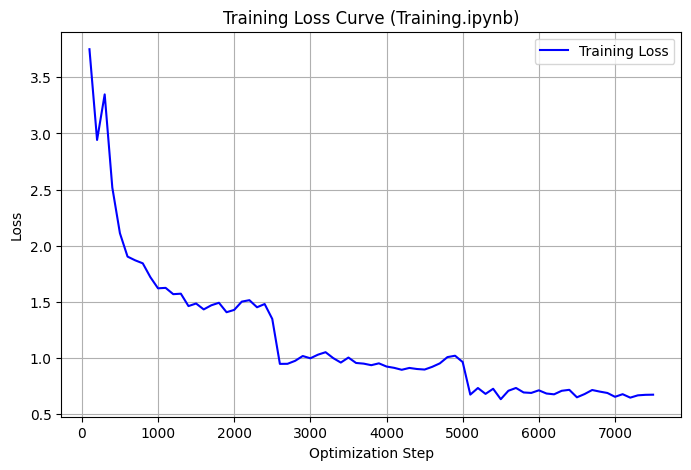

 Training Loss 곡선 시각화 완료.


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Trainer 로그 가져오기
log_history = trainer.state.log_history

# DataFrame으로 변환
df = pd.DataFrame(log_history)

# Training Loss 시각화
plt.figure(figsize=(8, 5))
df_train = df.dropna(subset=['loss'])
plt.plot(df_train['step'], df_train['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Curve (Training.ipynb)')
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(" Training Loss 곡선 시각화 완료.")

In [7]:
!pip install evaluate sacrebleu -q
print("evaluate 및 sacrebleu 라이브러리 설치 완료.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.8 MB/s eta 0:00:00
evaluate 및 sacrebleu 라이브러리 설치 완료.


In [11]:
import numpy as np
import evaluate

# sacrebleu 지표 로드 (Metric 객체 생성)
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    # 특수 토큰을 제거하고 공백을 기준으로 텍스트 정리
    preds = [pred.strip() for pred in preds]
    # sacrebleu는 레퍼런스를 리스트의 리스트 형태로 받기 때문에 변환합니다.
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # -100인 레이블(패딩)을 무시하고 유효한 레이블 ID만 추출
    # labels 배열에서 -100 (패딩)을 tokenizer.pad_token_id로 대체
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # 토큰 ID를 실제 텍스트로 디코딩
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 후처리 (공백 정리 및 레퍼런스 형식 맞추기)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # sacrebleu 계산
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    # 결과에서 score만 추출하여 반환
    return {"bleu": result["score"]}

In [12]:
eval_args = TrainingArguments(output_dir="./validation_output_temp", report_to="none")

eval_args.generation_config = None
eval_args.generation_max_length = 50
eval_args.generation_num_beams = 1

eval_args.predict_with_generate = True

# 3. Validation 평가용 Trainer 생성 및 실행
valid_trainer = Seq2SeqTrainer(
    model=trainer.model,
    args=eval_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=trainer.model),
    compute_metrics=compute_metrics
)

# 4. Validation Set에 대한 평가 실행
validation_results = valid_trainer.evaluate(tokenized_valid_datasets)

print("\n---  Validation 성능 모니터링 결과  ---")
print(f" Validation BLEU Score: {validation_results.get('eval_bleu'):.2f}")

/tmp/ipython-input-2104895734.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  valid_trainer = Seq2SeqTrainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.



---  Validation 성능 모니터링 결과  ---
 Validation BLEU Score: 24.14
